# Final Project - MLB Game Prediction
Parker Jackson

---
# Introduction

## Goal 
The primary objective of this project is to predict the outcome of an MLB game—specifically, whether the home team will win or lose. This is a binary classification problem where:
0. Home Team Loses
1. Home Team Wins

## Motivation
Baseball is an intricate and random game that I've enjoyed for almost my entire life. High variance is shown by the best model makers (and sports betting line makers) only able to predict the correct outcome around 53% of the time, barely better than a coin flip. This project aims to understand the biggest factors influencing the game outcome, compare the performance against various models, and practice solid data analysis techniques to offer solid and informational insights.  

---
# Data

## Source
The data was collected using the MLB-StatsAPI and covers the seasons from 2015 through 2025. Collected on 12/2/2025. Source: https://pypi.org/project/MLB-StatsAPI/ and Kaggle dataset `mlb-2015-thru-2025` (uploaded by me). The dataset contains game-level information including venue, weather conditions, team IDs, and performance metrics.

## Key Variables
- Target: `home_win` (binary)
- Context: `venue_id`, `temperature`, `wind_speed`, `condition`
- Team Stats: `win_percentage`, `run_differential`, `OPS`, `starting_pitcher_era`

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [21]:
df = pd.read_csv("data/mlb_2015_2025_dataset.csv", index_col=0)

---
# Data Preparation
To prepare the data for modeling, I performed extensive cleaning and feature engineering. A critical step was creating "differential" features (Home - Away) to better capture the relative strength of the teams rather than their absolute stats.

## Preprocessing Steps
1. Type Conversion: converted categorical features to `category` types, downcasting numerics to save memory
2. Handle Missing Data: only needed for weather conditions; dropped observations with "Unknown"
3. Merge external Park Factors: accounts for hitter-friendly vs. pitcher-friendly stadiums. Missing factors were filled with a neutral value (1.0). Ratings created by https://baseballsavant.mlb.com/leaderboard/statcast-park-factors 
4. Feature Engineering: Differentials - Calculated diff_run_diff, diff_ops, diff_starting_pitcher_era, etc. Rest & Schedule - Capped games_last_7 at 7 to remove outliers
5. Time-Based Splitting: Since this is sports data, random splitting would cause data leakage (using future games to predict past ones). Only using time-based split

In [22]:
# optimize and change data types
df['date'] = pd.to_datetime(df['date'])                                                 # ensure dates are proper type
df = df[df['condition'] != 'Unknown']
df["condition"] = df["condition"].astype("category")                                    # weather conditions --> category
df["home_team"] = df["home_team"].astype("category")                                    # team id's and venue id are not numeric --> category
df["away_team"] = df["away_team"].astype("category")
df["venue_id"] = df["venue_id"].astype("category")
int_cols = df.select_dtypes(include=["int"])
df[int_cols.columns] = df[int_cols.columns].apply(pd.to_numeric, downcast="integer")    # downcast ints
float_cols = df.select_dtypes(include=["float"])
df[float_cols.columns] = df[float_cols.columns].apply(pd.to_numeric, downcast="float")  # downcast floats

# Load and merge park factors
park_factors = pd.read_csv("data/venue_park_factors.csv")
park_factors['venue_id'] = park_factors['venue_id'].astype("category")

# Merge park factors with main dataset
df = df.merge(
    park_factors[['venue_id', 'park_factor']],
    on='venue_id',
    how='left'
)

# Fill any missing park factors with neutral value (100)
df['park_factor'] = df['park_factor'].fillna(100)

# Normalize park factor to be centered around 1.0 instead of 100
df['park_factor'] = df['park_factor'] / 100

# ensure value ranges are correct
df['home_games_last_7'] = df['home_games_last_7'].clip(upper=7)                         # ensure "last 7" can't be greater than 7
df['away_games_last_7'] = df['away_games_last_7'].clip(upper=7)

# add values
# df["away_win"] = df["home_win"] * -1 + 1
df['diff_wins_last_5']  = df['home_wins_last_5'] - df['away_wins_last_5']
df['diff_run_diff']     = df['home_run_diff'] - df['away_run_diff']                         # difference in run differentials
df['diff_avg']          = df['home_avg'] - df['away_avg']                                        # difference in batting average
df['diff_ops']          = df['home_ops'] - df['away_ops']                                        # difference in OPS
df['diff_era']          = df['home_starter_era'] - df['away_starter_era']                        # difference in starter ERA
df['diff_whip']         = df['home_starter_whip'] - df['away_starter_whip']                     # difference in starter WHIP
df['diff_rest']         = df['home_rest'] - df['away_rest']                                     # difference in rest days
df['diff_games_last_7'] = df['home_games_last_7'] - df['away_games_last_7']             # difference in games in last 7 days
df['diff_win_pct']      = df['home_win_pct'] - df['away_win_pct']                            # difference in win percentage

del int_cols, float_cols
df.head(20)

,year,date,home_team,away_team,venue_id,temp,wind_speed,condition,home_rest,away_rest,...,park_factor,diff_wins_last_5,diff_run_diff,diff_avg,diff_ops,diff_era,diff_whip,diff_rest,diff_games_last_7,diff_win_pct
0,2015,2015-04-05,112,138,17,44,7,Clear,5,5,...,0.97,0,0.0,0.000,0.000,0.0,0.0,0,0,0.0
1,2015,2015-04-06,136,108,680,54,1,Cloudy,5,5,...,0.91,0,0.0,0.000,0.000,0.0,0.0,0,0,0.0
2,2015,2015-04-06,146,144,4169,80,16,Partly Cloudy,5,5,...,1.01,0,0.0,0.000,0.000,0.0,0.0,0,0,0.0
3,2015,2015-04-06,139,110,12,72,0,Dome,5,5,...,1.00,0,0.0,0.000,0.000,0.0,0.0,0,0,0.0
4,2015,2015-04-06,143,111,2681,71,11,Partly Cloudy,5,5,...,1.01,0,0.0,0.000,0.000,0.0,0.0,0,0,0.0
5,2015,2015-04-06,118,145,7,59,6,Drizzle,5,5,...,1.01,0,0.0,0.000,0.000,0.0,0.0,0,0,0.0
6,2015,2015-04-06,117,114,2392,79,14,Partly Cloudy,5,5,...,1.00,0,0.0,0.000,0.000,0.0,0.0,0,0,0.0
7,2015,2015-04-06,158,115,32,70,0,Roof Closed,5,5,...,0.97,0,0.0,0.000,0.000,0.0,0.0,0,0,0.0
8,2015,2015-04-06,116,142,2394,52,5,Partly Cloudy,5,5,...,1.00,0,0.0,0.000,0.000,0.0,0.0,0,0,0.0
9,2015,2015-04-06,120,121,3309,76,14,Sunny,5,5,...,1.01,0,0.0,0.000,0.000,0.0,0.0,0,0,0.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25572 entries, 0 to 25571
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   year               25572 non-null  int16         
 1   date               25572 non-null  datetime64[ns]
 2   home_team          25572 non-null  category      
 3   away_team          25572 non-null  category      
 4   venue_id           25572 non-null  int64         
 5   temp               25572 non-null  int8          
 6   wind_speed         25572 non-null  int8          
 7   condition          25572 non-null  category      
 8   home_rest          25572 non-null  int8          
 9   away_rest          25572 non-null  int8          
 10  home_games_last_7  25572 non-null  int8          
 11  away_games_last_7  25572 non-null  int8          
 12  home_win_pct       25572 non-null  float32       
 13  home_ops           25572 non-null  float32       
 14  home_a

In [24]:
df.describe()

,year,date,venue_id,temp,wind_speed,home_rest,away_rest,home_games_last_7,away_games_last_7,home_win_pct,...,park_factor,diff_wins_last_5,diff_run_diff,diff_avg,diff_ops,diff_era,diff_whip,diff_rest,diff_games_last_7,diff_win_pct
count,25572.000000,25572,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,...,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000,25572.000000
mean,2020.003989,2020-07-06 16:46:30.802440192,1457.869036,73.507352,7.103903,0.204247,0.200415,5.917762,5.923275,0.498708,...,1.000640,0.043876,0.009397,0.000085,0.000432,0.034967,0.005973,0.003832,-0.005514,0.000905
min,2015.000000,2015-04-05 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.910000,-5.000000,-30.000000,-0.276000,-0.786000,-187.410004,-17.270000,-14.000000,-5.000000,-1.000000
25%,2017.000000,2017-07-24 00:00:00,12.000000,68.000000,4.000000,0.000000,0.000000,6.000000,6.000000,0.439000,...,0.980000,-1.000000,-0.900000,-0.013000,-0.041000,-1.230000,-0.210000,0.000000,0.000000,-0.090000
50%,2020.000000,2020-08-30 00:00:00,32.000000,74.000000,7.000000,0.000000,0.000000,6.000000,6.000000,0.500000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2023.000000,2023-06-14 00:00:00,2681.000000,80.000000,10.000000,0.000000,0.000000,7.000000,7.000000,0.565000,...,1.010000,1.000000,0.910000,0.013000,0.040000,1.330000,0.220000,0.000000,0.000000,0.090000
max,2025.000000,2025-11-01 00:00:00,6130.000000,113.000000,36.000000,6.000000,16.000000,7.000000,7.000000,1.000000,...,1.130000,5.000000,30.000000,0.317000,0.873000,131.759995,20.080000,5.000000,5.000000,1.000000
std,3.255710,NaN,1630.625086,10.374343,4.940200,0.642511,0.637980,1.177196,1.175191,0.121041,...,0.033988,1.843478,1.709023,0.024970,0.075999,3.800709,0.551964,0.339863,0.801387,0.182162


---
# EDA

## Correlation Analysis

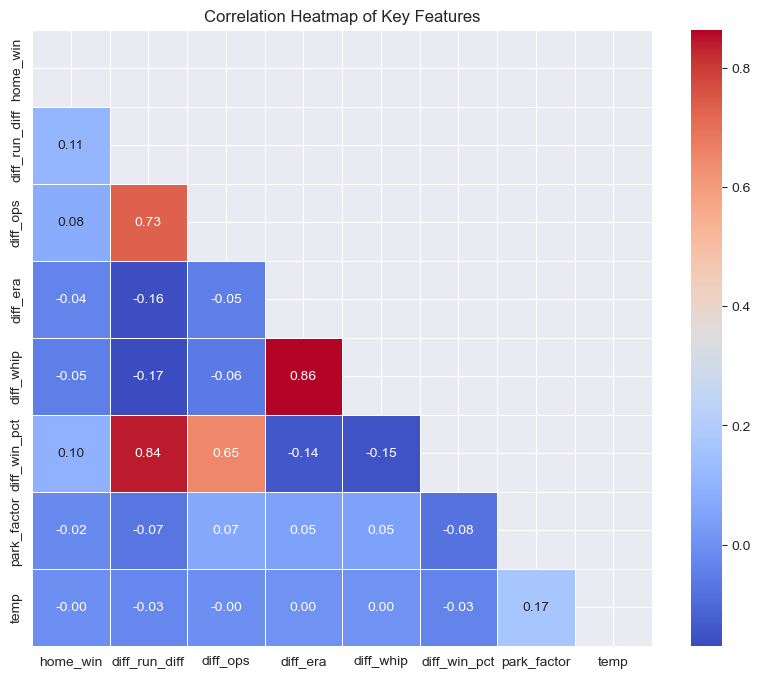

In [25]:
# Correlation Matrix for numeric features
corr_features = ['home_win', 'diff_run_diff', 'diff_ops', 'diff_era', 'diff_whip', 'diff_win_pct', 'park_factor', 'temp']
corr_matrix = df[corr_features].corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, mask=mask)
plt.title('Correlation Heatmap of Key Features')
plt.show()

The heatmap below reveals that diff_run_diff (Run Differential) and diff_ops (On-base Plus Slugging) have the strongest positive correlation with the home team winning, while diff_era and diff_whip (pitching stats) are negatively correlated, as expected (lower ERA is better).  

## Rest Advantage

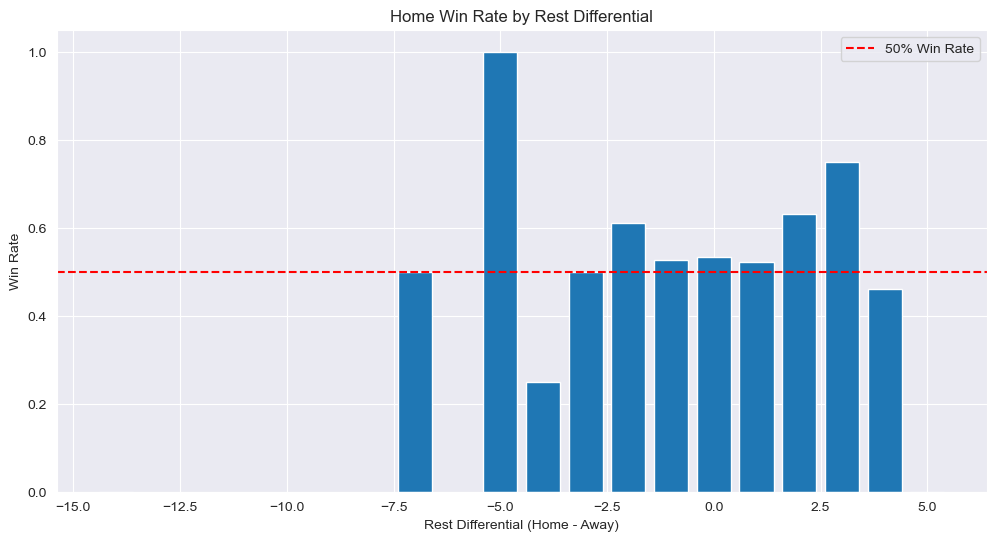

In [26]:
# Rest impact analysis
rest_analysis = df.groupby('diff_rest').agg({'home_win': ['mean', 'count']}).round(3)
rest_analysis.columns = ['Home Win Rate', 'Games']

plt.figure(figsize=(12, 6))
plt.bar(rest_analysis.index, rest_analysis['Home Win Rate'])
plt.axhline(0.5, color='red', linestyle='--', label='50% Win Rate')
plt.title('Home Win Rate by Rest Differential')
plt.xlabel('Rest Differential (Home - Away)')
plt.ylabel('Win Rate')
plt.legend()
plt.show()

I also analyzed if having more rest days than the opponent conferred an advantage.  

--- 
# Modeling

## Experimental Design
- Evaluation Metric: Accuracy and ROC-AUC.
- Validation Strategy: Time-series split.
- Training Set: Seasons 2015–2023
- Test Set: Seasons 2024–2025
- Baseline: The "Naive" baseline (always predicting the home team wins) yields an accuracy of roughly 53-54%.

## Models Evaluated
I evaluated several models, progressing from simple linear baselines to ensemble methods:

1. Logistic Regression: Established a linear baseline.

2. Decision Tree: Captured non-linear interactions but prone to overfitting.

3. Random Forest: Evaluated as a primary ensemble model. It performed well and was crucial for calculating initial feature importance, but was ultimately surpassed by XGBoost in overall performance metrics.
4. XGBoost (Selected Best Model): Provided the best balance of bias and variance, handling the subtle signals in baseball data effectively.

In [27]:
# Feature Selection
features = [
    'diff_run_diff', 'diff_ops', 'diff_whip', 'diff_era',
    'diff_wins_last_10', 'diff_games_last_7', 'park_factor',
    'temp', 'wind_speed'
]

X = df[features]
y = df['home_win']

# Time-based split
train_mask = df['date'].dt.year < 2024
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[~train_mask], y[~train_mask]

# XGBoost Model (Best Parameters)
clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

clf.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None



---
# Performance Results

In [28]:
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.36      0.43      2309
           1       0.56      0.72      0.63      2628

    accuracy                           0.55      4937
   macro avg       0.54      0.54      0.53      4937
weighted avg       0.55      0.55      0.54      4937



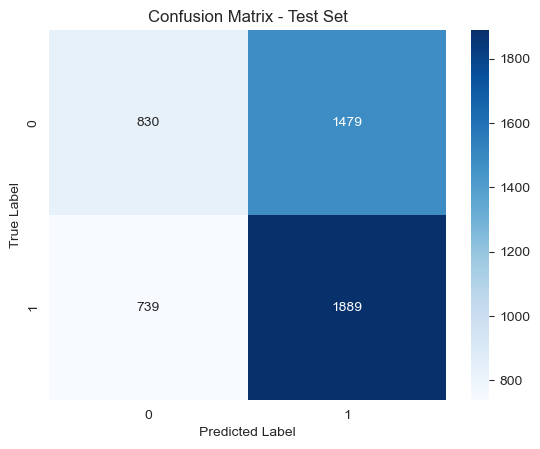

In [29]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

ROC-AUC Score: 0.564


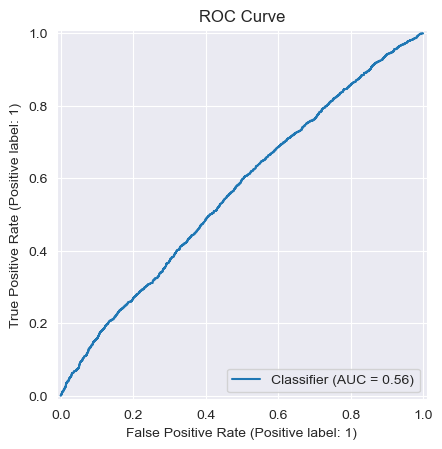

In [30]:
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_probs):.3f}")
RocCurveDisplay.from_predictions(y_test, y_probs)
plt.title("ROC Curve")
plt.show()

---
# Discussion

A key finding in this project was the dominance of Run Differential (`diff_run_diff`) as a predictor. This single metric summarizes a team's offensive and defensive efficiency better than win-loss record alone.

In the XGBoost model, we observed that while Run Differential remained top, other factors like `diff_ops` (offense) and `diff_whip` (pitching) played significant roles. Interestingly, `diff_wins_last_10` (recent form/momentum) also showed moderate importance.

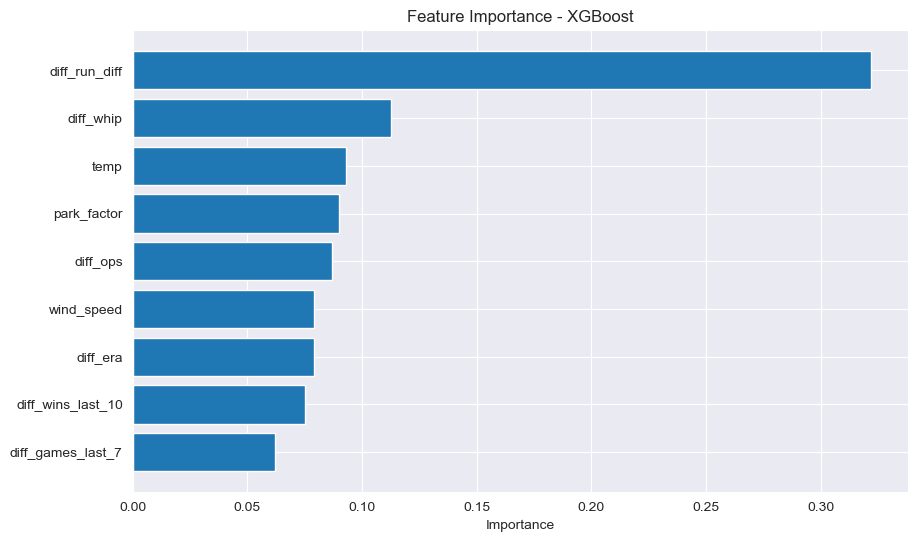

In [31]:
# Feature Importance Plot
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.show()

## Challenges
- Noise: Baseball is inherently random. Even the best models struggle to exceed 60% accuracy.

- Multicollinearity: Features like OPS, Batting Average, and Run Differential are highly correlated. Using tree-based models (XGBoost) helped mitigate this better than Logistic Regression.

---
# Conclusions

This project successfully established a data pipeline for MLB prediction, transforming raw game logs into predictive "differential" features.

- Best Model: XGBoost with time-series validation.

- Key Insight: Team efficiency metrics (Run Diff, OPS) are far more predictive than simple Win/Loss records or home-field advantage factors like Rest or Weather.

 - Future Work: Integrating player-level injury data and starting lineup specifics could potentially squeeze out another 1-2% in accuracy.